# Scénario 2.3 - Minimisation des changements de sens des arêtes


Création du graphe initial et représentation graphique

In [1]:
"""
from google.colab import files
import os
import shutil

uploaded = files.upload()
dest_path = "/content/data/"
os.makedirs(os.path.dirname(dest_path), exist_ok=True)
shutil.move("/content/InputDataEnergyLargeInstance.xlsx", dest_path)
#shutil.move("/content/InputDataEnergySmallInstance.xlsx", dest_path)
shutil.rmtree("/content/sample_data/", ignore_errors=True, onerror=None)
"""

Saving InputDataEnergyLargeInstance.xlsx to InputDataEnergyLargeInstance.xlsx


In [2]:
!pip install pulp
!pip install networkx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 43.7 MB/s eta 0:00:00


In [3]:
# Import PuLP modeler functions
from pulp import *
import pandas as pd
import numpy as np

In [4]:
InputData = "/content/data/InputDataEnergyLargeInstance.xlsx"  # Large instance

In [5]:
# Input Data Preparation
def read_excel_data(filename, sheet_name):
  data = pd.read_excel(filename, sheet_name=sheet_name, header=None)
  values = data.values
  if min(values.shape) == 1:  # This If is to make the code insensitive to column-wise or row-wise expression
      if values.shape[0] == 1:
          values = values.tolist()
      else:
          values = values.transpose()
          values = values.tolist()
      return values[0]
  else:
      data_dict = {}
      if min(values.shape) == 2:  # For single-dimension parameters in Excel
          if values.shape[0] == 2:
              for i in range(values.shape[1]):
                  data_dict[i] = values[1][i]
          else:
              for i in range(values.shape[0]):
                  data_dict[i] = (values[i][0],values[i][1])

      else:  # For two-dimension (matrix) parameters in Excel
          for i in range(values.shape[0]):
              for j in range(values.shape[1]):
                  data_dict[(i, j)] = values[i][j]
      return data_dict


In [6]:
#parameters
Nodes = read_excel_data(InputData, "Nodes")
NodesCord = read_excel_data(InputData, "NodesCord")
V = [i for i in range(0,Nodes[0])]
E = [(i, j) for i in range(0, Nodes[0] ) for j in range(0, Nodes[0] )]
l={}
for i in range(Nodes[0]):
    for j in range(Nodes[0]):
        l[(i,j)]=((NodesCord[i][0]-NodesCord[j][0])**2+(NodesCord[i][1]-NodesCord[j][1])**2)**(1/2)

V0 = read_excel_data(InputData, "SourceNum")
for i in range(len(V0)):
  V0[i]=V0[i]-1
FixedUnitCost = read_excel_data(InputData, "FixedUnitCost")
vfix_thetaijfix = read_excel_data(InputData, "vfix(thetaijfix)")
vvar_thetaijvar = read_excel_data(InputData, "vvar(thetaijvar)")
cvar_cijvar = read_excel_data(InputData, "cvar(cijvar)")
cheat_ciheat = read_excel_data(InputData, "cheat(ciheat)")
com_cijom = read_excel_data(InputData, "com(cijom)")
crev_cijrev = read_excel_data(InputData, "crev(cijrev)")
Tflh_Tiflh = read_excel_data(InputData, "Tflh(Tiflh)")
Betta = read_excel_data(InputData, "Betta")
Lambda = read_excel_data(InputData, "Lambda")
Alpha = read_excel_data(InputData, "Alpha")
EdgesDemandPeak_dij = read_excel_data(InputData, "EdgesDemandPeak(dij)")
EdgesDemandAnnual_dij =  read_excel_data(InputData, "EdgesDemandAnnual(Dij)")
Cmax_cijmax = read_excel_data(InputData, "Cmax(cijmax)")
SourceMaxCap_Qimax = read_excel_data(InputData, "SourceMaxCap(Qimax)")
pumd_pijumd = read_excel_data(InputData, "pumd(pijumd)")

In [7]:
#decision variables
X=LpVariable.dicts("X",(V,V),lowBound=0,upBound=1,cat="Binary")
P_Out=LpVariable.dicts("P_Out",(V,V),lowBound=0,upBound=None,cat="Continuous")
P_In=LpVariable.dicts("P_In",(V,V),lowBound=0,upBound=None,cat="Continuous")
problem=LpProblem("problem",LpMinimize)

In [8]:

# Constraint 1
"""sum_x =[]
for i in range(len(V)):
  for j in range(len(V)):
    sum_x.append(X[i][j])"""
problem += lpSum([X[i][j] for i in range(len(V)) for j in range(len(V))]) == len(V) - 1

# Constraint 2
for i in range(len(V)):
    for j in range(i+1,len(V)):
        problem += lpSum([X[i][j],X[j][i]]) <= 1

# Constraint 3
for (i,j) in E:
    eta = 1 - vvar_thetaijvar[(i,j)]*l[(i,j)]
    delta = EdgesDemandPeak_dij[(i,j)]*Betta[0]*Lambda[0] + l[(i,j)]*vfix_thetaijfix[(i,j)]
    problem += lpSum([eta*P_In[i][j],-P_Out[i][j],-delta*X[i][j]]) == 0

# Constraint 4
"""for j in range(4,len(V)):
    sum_out_in= []
    for i in range(len(V)):
        if i != j:
            sum_out_in.append(P_Out[i][j])
            sum_out_in.append(-P_In[j][i])
            problem +=lpSum(sum_out_in) == 0"""
for j in range(0,len(V)):
  if j not in V0:
    problem += lpSum(P_Out[i][j]-P_In[j][i] for i in range(len(V)) if i != j) == 0

# Constraint 5
for i in range(len(V)):
  for j in range(len(V)):
    problem += lpSum([P_In[i][j],-X[i][j]*Cmax_cijmax[(i,j)] ]) <= 0

# Constraint 6
for v in V0:
  for i in range(len(V)):
    if i != v:
      problem += X[i][v] == 0
      problem += P_In[i][v] == 0
"""problem += sum_X == 0"""

# Constraint 7
for v in V0:
  sum_PIN =[]
  for i in range(len(V)):
      if i != v:
          sum_PIN.append(P_In[v][i])
  problem += lpSum(sum_PIN) <= SourceMaxCap_Qimax[0]

# Constraint 8
for i in range(0,len(V)):
  if i not in V0:
    summ=[]
    for j in range(len(V)):
        if j!=i:
          summ.append(X[j][i])
    problem += lpSum(summ) >= 1

# Constraint 9
for i in range(len(V)):
  for j in range(len(V)):
    problem += P_In[i][j] >= 0
    problem += P_Out[i][j] >= 0
    problem += X[i][j] >= 0
    problem += X[i][j] <= 1

In [9]:
#objective function
n=len(V)

#revenue
revenue=0
for i in range(n):
  for j in range(n):
    revenue+=crev_cijrev[(i,j)]*EdgesDemandAnnual_dij[(i,j)]*Lambda[0]*X[i][j]

#Heat generation
heat_generation=0
for j in range(n):
  for v in V0:
    heat_generation+=P_In[v][j]*Tflh_Tiflh[0]*cheat_ciheat[v]
heat_generation=(1/Betta[0])*heat_generation

#maintenance
maintenance=0
for i in range(n):
  for j in range(n):
    maintenance+=com_cijom[(i,j)]*l[(i,j)]*X[i][j]

#total fixed investment cost
total_fixed_investment_cost=0
for i in range(Nodes[0]):
    for j in range(Nodes[0]):
        total_fixed_investment_cost+=l[(i,j)]*FixedUnitCost[0]*X[i][j]*Alpha[0]

#total variable investment cost
total_var=0
for i in range(n):
  for j in range(n):
    total_var+=cvar_cijvar[(i,j)]*P_In[i][j]*l[(i,j)]*Alpha[0]

#unmet demand
unmet_demand=0
for i in range(n):
  for j in range(i+1,n):
    unmet_demand+=lpSum([1,-X[i][j],-X[j][i]])*pumd_pijumd[(i,j)]*EdgesDemandAnnual_dij[(i,j)]

#objective function
objective_function=-(revenue-heat_generation-maintenance-total_fixed_investment_cost-total_var-unmet_demand)
problem+=objective_function
problem.solve()
LpStatus[problem.status]


'Optimal'

In [10]:
for v in problem.variables():
  print(v.name,"=",v.varValue)
print("objective_function","=",value(problem.objective))


P_In_0_0 = 0.0
P_In_0_1 = 0.0
P_In_0_10 = 0.0
P_In_0_11 = 0.0
P_In_0_12 = 0.0
P_In_0_13 = 0.0
P_In_0_14 = 0.0
P_In_0_15 = 0.0
P_In_0_16 = 0.0
P_In_0_17 = 0.0
P_In_0_18 = 0.0
P_In_0_19 = 0.0
P_In_0_2 = 0.0
P_In_0_20 = 0.0
P_In_0_21 = 0.0
P_In_0_22 = 0.0
P_In_0_23 = 0.0
P_In_0_24 = 0.0
P_In_0_25 = 803.49357
P_In_0_26 = 0.0
P_In_0_27 = 0.0
P_In_0_28 = 0.0
P_In_0_29 = 0.0
P_In_0_3 = 0.0
P_In_0_4 = 0.0
P_In_0_5 = 0.0
P_In_0_6 = 0.0
P_In_0_7 = 0.0
P_In_0_8 = 0.0
P_In_0_9 = 0.0
P_In_10_0 = 0.0
P_In_10_1 = 0.0
P_In_10_10 = 0.0
P_In_10_11 = 0.0
P_In_10_12 = 0.0
P_In_10_13 = 0.0
P_In_10_14 = 0.0
P_In_10_15 = 0.0
P_In_10_16 = 0.0
P_In_10_17 = 0.0
P_In_10_18 = 0.0
P_In_10_19 = 0.0
P_In_10_2 = 0.0
P_In_10_20 = 0.0
P_In_10_21 = 0.0
P_In_10_22 = 0.0
P_In_10_23 = 0.0
P_In_10_24 = 0.0
P_In_10_25 = 0.0
P_In_10_26 = 0.0
P_In_10_27 = 0.0
P_In_10_28 = 0.0
P_In_10_29 = 0.0
P_In_10_3 = 0.0
P_In_10_4 = 0.0
P_In_10_5 = 0.0
P_In_10_6 = 0.0
P_In_10_7 = 926.74228
P_In_10_8 = 0.0
P_In_10_9 = 0.0
P_In_11_0 = 0.0
P_

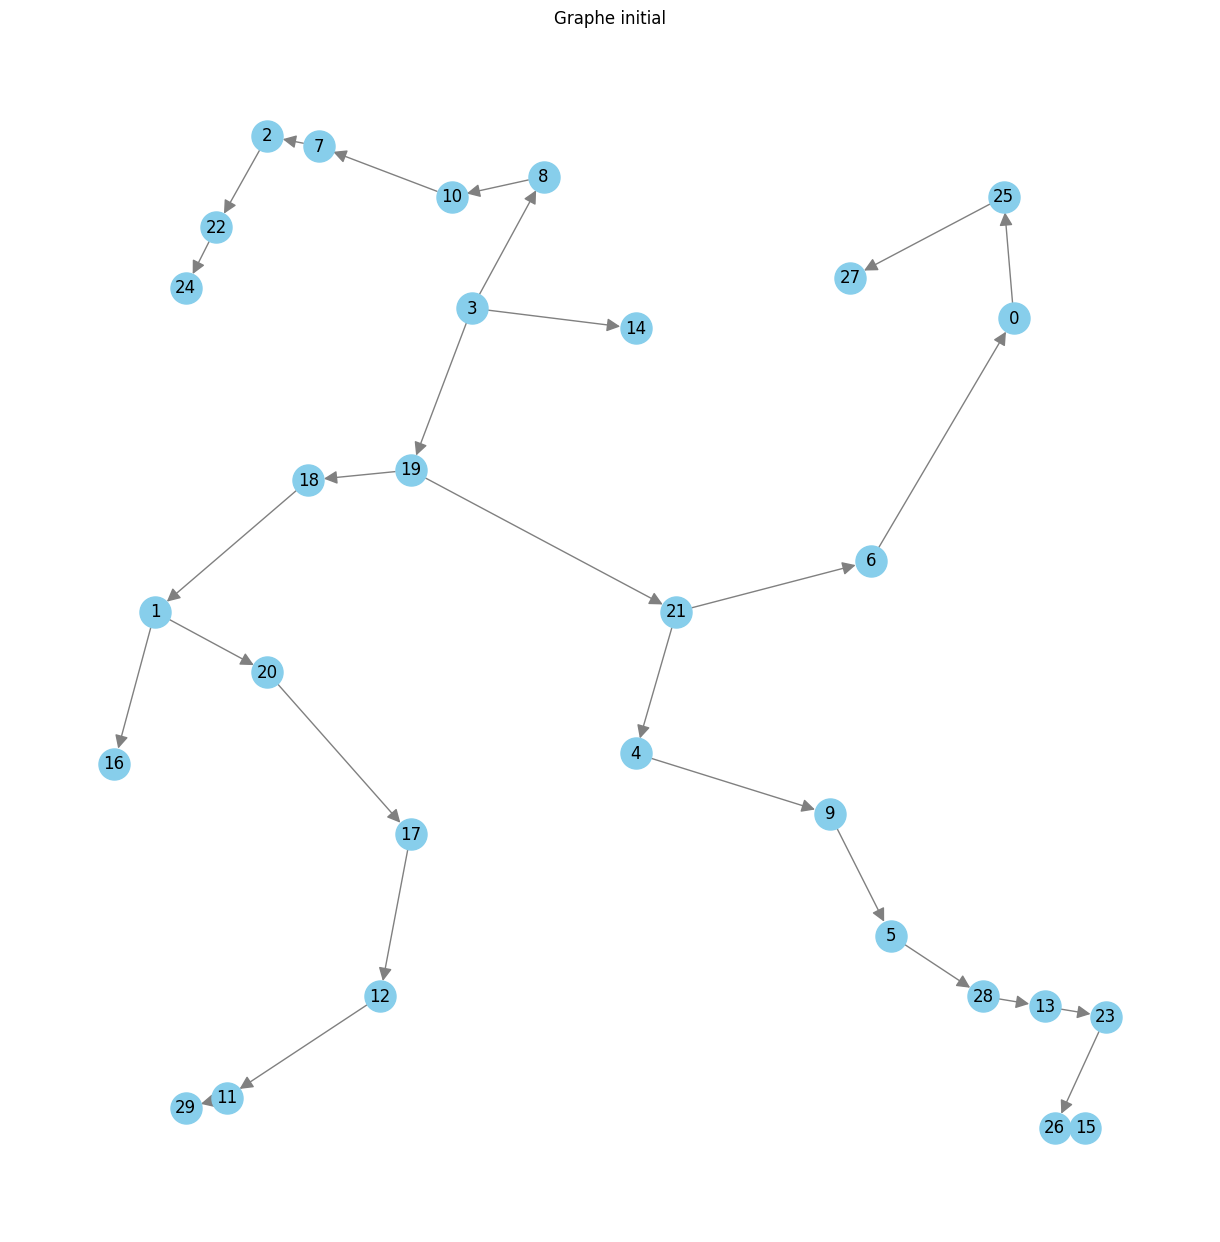

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

# Extract edges from the solution
edges = []
for var in problem.variables():
    if var.name.startswith("X_") and var.varValue == 1:
        # Parse indices (e.g., "X_0_25" -> (0, 25))
        parts = var.name.split("_")
        i = int(parts[1])
        j = int(parts[2])
        edges.append((i, j))

# Create a directed graph
G = nx.DiGraph()

# Add nodes
G.add_nodes_from(V)

# Add edges
G.add_edges_from(edges)

# Extract node coordinates from NodesCord (convert np.int64 to float)
pos = {node: (float(NodesCord[node][0]), float(NodesCord[node][1])) for node in NodesCord}

# Draw the graph
plt.figure(figsize=(12, 12))
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=500,
        edge_color='gray', arrows=True, arrowsize=20)
plt.title("Graphe initial")
plt.show()

# Cas d'une panne

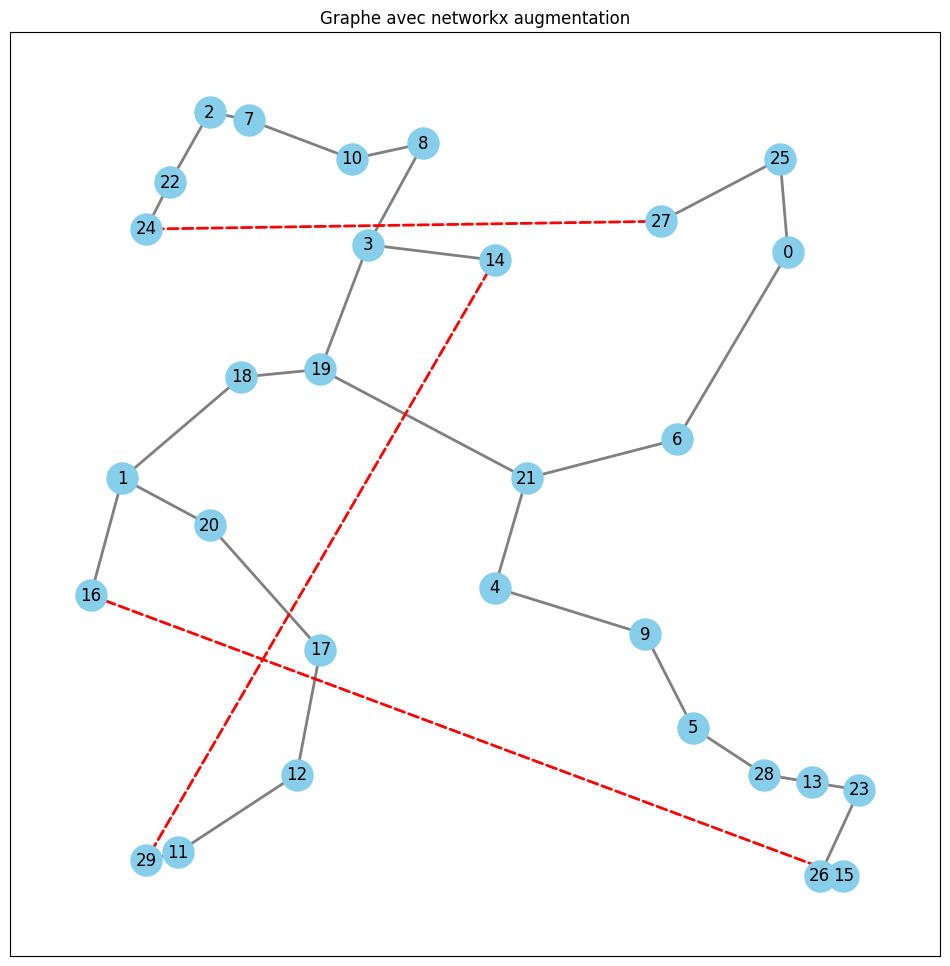

In [12]:
import networkx as nx
import random

# --- 0. Graphe de départ orienté (issu de l'optimisation)
# On suppose que G est déjà défini comme un nx.DiGraph()

# --- 1. Convertir en non orienté pour l’analyse
G_undirected = G.to_undirected()
G_base2 = G_undirected.copy()     # Arbre initial
G_modified2 = G_undirected.copy() # Copie à modifier (arêtes de secours seront ajoutées ici)

edges_backup = list(nx.k_edge_augmentation(G_modified2, 2))
edges_base = G.edges()

plt.figure(figsize=(12, 12))
# Dessiner les nœuds et labels
nx.draw_networkx_nodes(G_modified2, pos, node_color='skyblue', node_size=500)
nx.draw_networkx_labels(G_modified2, pos)

# Arêtes de base : gris
nx.draw_networkx_edges(G_modified2, pos,
    edgelist=edges_base,
    edge_color='gray',
    width=2,
    arrows=True,
    arrowsize=20
)

# Arêtes de secours : rouge pointillé
nx.draw_networkx_edges(G_modified2, pos,
    edgelist=edges_backup,
    edge_color='red',
    style='dashed',
    width=2,
    arrows=True,
    arrowsize=20
)
plt.title("Graphe avec networkx augmentation")
plt.show()
plt.show()

[3]
[3, 14]
[3, 19]
[3, 8]
[3, 14, 29]
[3, 19, 18]
[3, 19, 21]
[3, 8, 10]
[3, 19, 21, 4]
[3, 19, 21, 6]
[3, 8, 10, 7]
[3, 19, 21, 4, 9]
[3, 19, 21, 6, 0]
[3, 8, 10, 7, 2]
[3, 19, 21, 4, 9, 5]
[3, 19, 21, 6, 0, 25]
[3, 8, 10, 7, 2, 22]
[3, 19, 21, 4, 9, 5, 28]
[3, 19, 21, 6, 0, 25, 27]
[3, 8, 10, 7, 2, 22, 24]
[3, 19, 21, 4, 9, 5, 28, 13]
[3, 19, 21, 4, 9, 5, 28, 13, 23]
[3, 19, 21, 4, 9, 5, 28, 13, 23, 26]
[3, 19, 21, 4, 9, 5, 28, 13, 23, 26, 15]
[3, 19, 21, 4, 9, 5, 28, 13, 23, 26, 15, 16]
[3, 14, 29, 11]
[3, 19, 21, 4, 9, 5, 28, 13, 23, 26, 15, 16, 1]
[3, 19, 21, 4, 9, 5, 28, 13, 23, 26, 15, 16, 1, 20, 17, 12]
[3, 19, 21, 4, 9, 5, 28, 13, 23, 26, 15, 16, 1, 20]
[3, 19, 21, 4, 9, 5, 28, 13, 23, 26, 15, 16, 1, 20, 17]


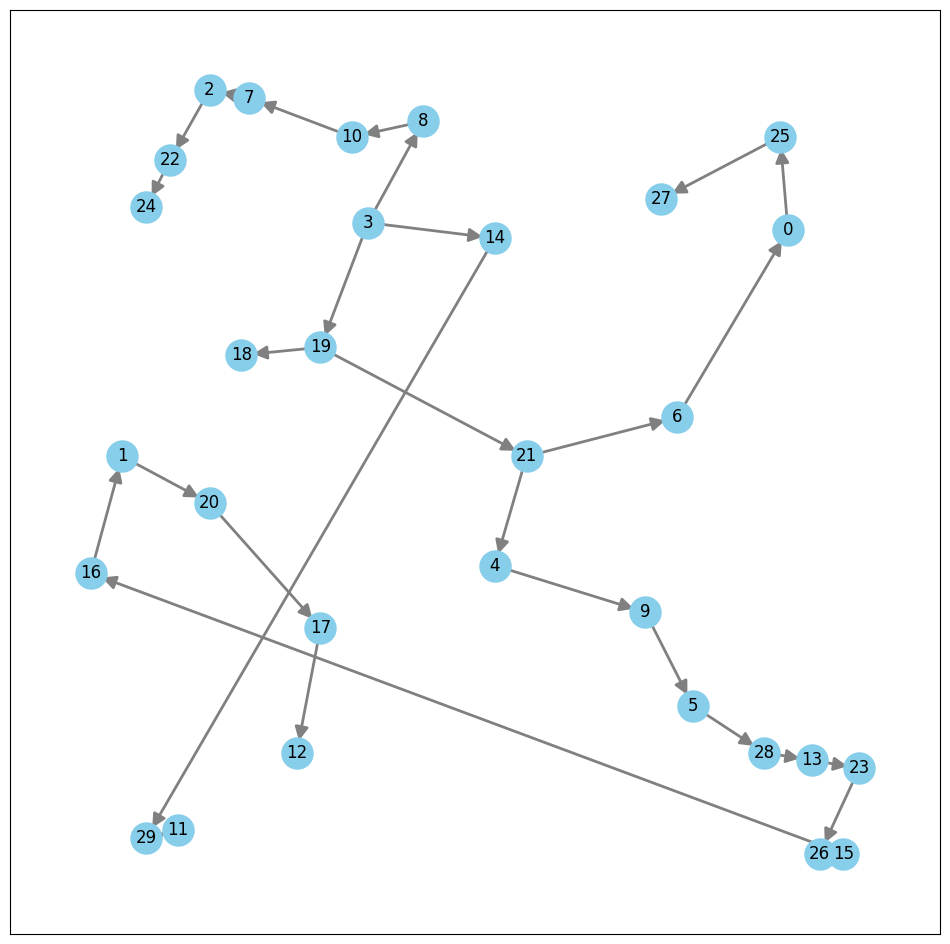

In [13]:

def panne_2(u,v):
  G_res = G.to_undirected().copy()   # copie locale du graphe de base
  G_res.remove_edge(u,v)
  for e in edges_backup:
    G_res.add_edge(e[0],e[1])
  # 1) On crée D, un DiGraph vide
  D = nx.DiGraph()
  T_init=G.copy()
  # 2) Pour chaque arête non orientée de G_resilient...
  for u, v in G_res.edges():
    # on détermine si (u->v) ou (v->u) appartiennent à l'arbre initial dirigé
    in_init_uv = T_init.has_edge(u, v)
    in_init_vu = T_init.has_edge(v, u)

    # on fixe les poids
    if in_init_uv:
        w_uv = 0
    elif in_init_vu:
        w_uv = 1000
    else:
        w_uv = 1

    if in_init_vu:
        w_vu = 0
    elif in_init_uv:
        w_vu = 1000
    else:
        w_vu = 1

    # ajoute les deux arêtes dirigées avec leurs poids
    D.add_edge(u, v, weight=w_uv)
    D.add_edge(v, u, weight=w_vu)
  paths = nx.single_source_dijkstra_path(D, source=3, weight='weight')

  T_final = nx.DiGraph()


  for node, path in paths.items():
    print(path)
    # on saute la source elle-même
    for u, v in zip(path, path[1:]):
        w = D[u][v]['weight']
        T_final.add_edge(u, v,weight=w)

  return T_final

G_panne_2 = panne_2(18, 1)

plt.figure(figsize=(12, 12))
# Dessiner les nœuds et labels
nx.draw_networkx_nodes(G_panne_2, pos, node_color='skyblue', node_size=500)
nx.draw_networkx_labels(G_panne_2, pos)


# Arêtes de base : gris
nx.draw_networkx_edges(G_panne_2, pos,
    edgelist=G_panne_2.edges,
    edge_color='gray',
    width=2,
    arrows=True,
    arrowsize=20
)
